# Workshop on Domain-Specific Lanugages for Performance-Portable Weather and Climate Models

## Session 1B: More Basic Concepts

This notebook begins by revisiting the laplacian example from the previous session, only this time with a GPU!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import timeit

import gt4py
from gt4py import gtscript
from gt4py.gtscript import Field

In [15]:
def laplacian_def(in_field: Field[np.float64], out_field: Field[np.float64], *, coeff: float):
    with computation(PARALLEL), interval(...):
        out_field = coeff * (-4. * in_field +
            in_field[1, 0, 0] + in_field[-1, 0, 0] + 
            in_field[0, 1, 0] + in_field[0, -1, 0])

In [17]:
ni, nj, nk = 24, 24, 79
nhalo = 3
nruns = 5

In [23]:
backends = ["numpy", "gtx86", "gtmc"]  # , "gtcuda]"
timings = dict()
sizes = dict()

for backend in backends:
    ni = nj = 24
    sizes[backend] = []
    timings[backend] = []    

    for n in range(0, nruns):
        print(f"Running with {backend} backend ({n})...")
        
        in_field = gt4py.storage.from_array(
            np.random.randn(ni + 2*nhalo, nj + 2*nhalo, nk), backend, (nhalo, nhalo, 0), (ni + 2*nhalo, nj + 2*nhalo, nk), dtype=np.float64
        )
        out_field = 0. * in_field.copy()

        laplacian = gtscript.stencil(backend, laplacian_def, rebuild=False)
        
        fields = {"in_field": in_field, "out_field": out_field}
        scalars = {"coeff": 0.125}
        exec_info = {}
        
        laplacian(**fields, **scalars, origin=(nhalo, nhalo, 0), domain=(ni, nj, nk), exec_info=exec_info, validate_args=False)
        
        call_time = (exec_info['call_end_time']-exec_info['call_start_time']) * 1000.
        run_time = (exec_info['run_end_time']-exec_info['run_start_time']) * 1000.
        
        timings[backend].append(run_time)
        sizes[backend].append(ni)

        ni *= 2
        nj = ni

        print(f"  call_time = {call_time} ms")
        print(f"  run_time = {run_time} ms")
        print(f"  overhead = {(call_time - run_time)} ms")
        print("")


Running with numpy backend (0)...
  call_time = 0.9052169625647366 ms
  run_time = 0.6759410025551915 ms
  overhead = 0.2292759600095451 ms

Running with numpy backend (1)...
  call_time = 3.4360860008746386 ms
  run_time = 3.1726480228826404 ms
  overhead = 0.2634379779919982 ms

Running with numpy backend (2)...
  call_time = 10.557675966992974 ms
  run_time = 10.276150016579777 ms
  overhead = 0.2815259504131973 ms

Running with numpy backend (3)...
  call_time = 41.60432395292446 ms
  run_time = 41.15114698652178 ms
  overhead = 0.4531769664026797 ms

Running with numpy backend (4)...
  call_time = 154.555958986748 ms
  run_time = 154.26671702880412 ms
  overhead = 0.2892419579438865 ms

Running with gtx86 backend (0)...
  call_time = 0.4373340052552521 ms
  run_time = 0.12871698709204793 ms
  overhead = 0.3086170181632042 ms

Running with gtx86 backend (1)...
  call_time = 0.7145170238800347 ms
  run_time = 0.36738201742991805 ms
  overhead = 0.34713500645011663 ms

Running with g

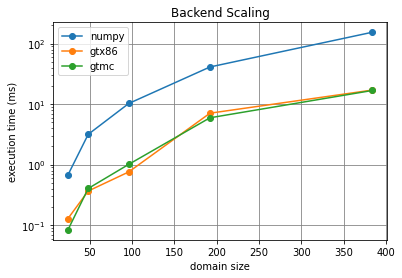

In [24]:
for backend in backends:
    plt.plot(sizes[backend], timings[backend], "-o", label=backend)

plt.title("Backend Scaling")
plt.grid(color="gray", linestyle='-')
plt.legend()
plt.xlabel("domain size")
plt.ylabel("execution time (ms)")
plt.yscale("log")

plt.show()

In [ ]:
@gtstencil()
def counts_and_sums(
    q: FloatField,
    dp: FloatField,
    dm: FloatField,    
    zfix: IntFieldIJ,    
    sum: FloatFieldIJ,    
):
    with computation(PARALLEL), interval(...):
        zfix = 0
        sum = 0.0
    with computation(FORWARD), interval(1, -1):
        if (q < 0.0) and (q[0, 0, -1] > 0.0):
            zfix += 1
            q += (q[0, 0, -1] * dp[0, 0, -1]) / dp
        dm = q * dp        
    with computation(FORWARD), interval(1, None):
        sum += dm
        if zfix > 0:
            q = sum * dm / dp if sum * dm / dp > 0.0 else 0.0